## Final Project Check-in

## Group Name: we don't have one...

## Student Name:
1. Lin Meng
2. Matt Sarmiento
3. Qingyi Sun 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import time
import datetime
import gc

In [2]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## load data

In [3]:
building_metadata = pd.read_csv("data/building_metadata.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
test = pd.read_csv("data/test.csv", parse_dates=['timestamp'])
train = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
weather_test = pd.read_csv("data/weather_test.csv", parse_dates=['timestamp'])
weather_train = pd.read_csv("data/weather_train.csv", parse_dates=['timestamp'])

> ### missing values

In [4]:
print(building_metadata.isna().sum())

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64


In [5]:
building_metadata.isna().sum()/len(building_metadata)

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

Since `floor_count` has 76% missing data, I am considering to drop this column.

In [6]:
building_metadata.drop('floor_count',axis=1,inplace=True)

In [7]:
# building_metadata.head()

In [8]:
print('weather_train set missing data')
print(weather_train.isna().sum())
print('------------------------------')
print('weather_test set missing data')
print(weather_test.isna().sum())

weather_train set missing data
site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64
------------------------------
weather_test set missing data
site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64


In [9]:
missing_weather = pd.DataFrame(weather_train.isna().sum()/len(weather_train), columns=["missing% in weather_train"])
missing_weather["missing% in weather_test"] = weather_test.isna().sum()/len(weather_test)
missing_weather

,missing% in weather_train,missing% in weather_test
site_id,0.000000,0.000000
timestamp,0.000000,0.000000
air_temperature,0.000393,0.000375
cloud_coverage,0.494895,0.506588
dew_temperature,0.000808,0.001179
precip_depth_1_hr,0.359791,0.344781
sea_level_pressure,0.075966,0.076702
wind_direction,0.044844,0.044618
wind_speed,0.002175,0.001659


In [10]:
missing_main = pd.DataFrame(train.isna().sum()/len(train), columns=["missing% in train"])
missing_main["missing% in test"] = test.isna().sum()/len(test)
missing_main

,missing% in train,missing% in test
building_id,0.0,0.0
meter,0.0,0.0
timestamp,0.0,0.0
meter_reading,0.0,NaN


### EDA

#### train set
* we already know there is no missing data in the train data set.

In [11]:
train.describe(include='all')

,building_id,meter,timestamp,meter_reading
count,2.021610e+07,2.021610e+07,20216100,2.021610e+07
unique,NaN,NaN,8784,NaN
top,NaN,NaN,2016-12-27 22:00:00,NaN
freq,NaN,NaN,2370,NaN
first,NaN,NaN,2016-01-01 00:00:00,NaN
last,NaN,NaN,2016-12-31 23:00:00,NaN
mean,7.992780e+02,6.624412e-01,NaN,2.117121e+03
std,4.269133e+02,9.309921e-01,NaN,1.532356e+05
min,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,3.930000e+02,0.000000e+00,NaN,1.830000e+01


In [12]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


Text(0, 0.5, 'Frequency')

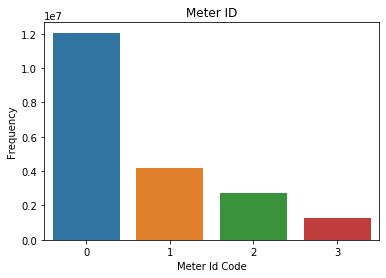

In [13]:
# 'meter' column is a dummy variable.
# 0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"
sns.countplot(train['meter'])
plt.title("Meter ID")
plt.xlabel("Meter Id Code")
plt.ylabel("Frequency")

In [14]:
# building ID
print(train['building_id'].nunique())

1449


Text(0.5, 1.0, 'log(meter_reading)')

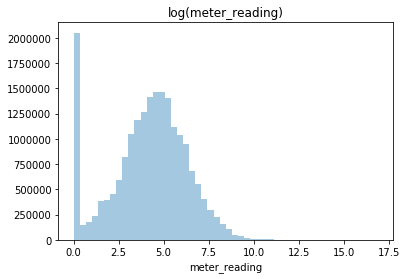

In [15]:
# meter_reading
sns.distplot(np.log1p(train['meter_reading']), kde=False)
plt.title("log(meter_reading)")

In [16]:
train.groupby('meter')['meter_reading'].agg(['count', 'min','max','mean','median','std'])

,count,min,max,mean,median,std
meter,,,,,,
0,12060910,0.0,79769.0,170.825636,62.8319,380.834307
1,4182440,0.0,880374.0,633.363924,120.4870,7988.213146
2,2708713,0.0,21904700.0,13882.187689,257.8120,418313.503638
3,1264037,0.0,160187.0,385.866781,39.6237,2508.172498


In [17]:
# timestamp
for record in [train, test]:
    record['Month'] = record['timestamp'].dt.month.astype("uint8")
    record['DayOfMonth'] = record['timestamp'].dt.day.astype("uint8")
    record['DayOfWeek'] = record['timestamp'].dt.dayofweek.astype("uint8")
    record['Hour'] = record['timestamp'].dt.hour.astype("uint8")

In [18]:
train.head()

,building_id,meter,timestamp,meter_reading,Month,DayOfMonth,DayOfWeek,Hour
0,0,0,2016-01-01,0.0,1,1,4,0
1,1,0,2016-01-01,0.0,1,1,4,0
2,2,0,2016-01-01,0.0,1,1,4,0
3,3,0,2016-01-01,0.0,1,1,4,0
4,4,0,2016-01-01,0.0,1,1,4,0


In [19]:
test.head()

,row_id,building_id,meter,timestamp,Month,DayOfMonth,DayOfWeek,Hour
0,0,0,0,2017-01-01,1,1,6,0
1,1,1,0,2017-01-01,1,1,6,0
2,2,2,0,2017-01-01,1,1,6,0
3,3,3,0,2017-01-01,1,1,6,0
4,4,4,0,2017-01-01,1,1,6,0


In [20]:
train.groupby(['DayOfWeek'])['meter_reading'].agg(['count', 'max','mean','median','std'])

,count,max,mean,median,std
DayOfWeek,,,,,
0,2871227,21904700.0,1967.816997,81.8800,143561.254033
1,2873589,21382500.0,2267.786315,84.2600,164549.218220
2,2876088,21847900.0,2485.819959,83.9688,176475.814571
3,2875944,21508500.0,2263.206170,84.0000,159903.297136
4,2927218,21889900.0,2151.439219,81.4900,156872.474338
5,2925717,21724400.0,1865.434390,69.0805,133678.418565
6,2866317,20629700.0,1820.957143,67.3064,132456.882993


In [21]:
train.groupby(['meter', 'DayOfWeek'])['meter_reading'].agg(['count', 'max','mean','median','std'])

count         max          mean     median            std
meter DayOfWeek                                                             
0     0          1711905     79769.0    175.686222   65.27000     399.705499
      1          1714778     19511.0    179.134665   67.65825     399.705281
      2          1715699     44336.5    179.199962   67.60000     403.142946
      3          1715180     17999.0    178.709908   67.48000     398.823510
      4          1745679     25275.0    174.842095   65.04000     392.604412
      5          1746705     31921.0    155.521126   55.29170     333.597049
      6          1710964     31921.0    152.859887   53.80000     329.086615
1     0           595214    793065.0    649.261667  125.83300    8312.484350
      1           594969    751685.0    671.752610  132.28000    8489.064247
      2           594893    849418.0    652.510875  130.40500    7700.235803
      3           595478    828374.0    645.291940  133.44850    7529.126686
      4           606214    880374.0    633.130978  123.95000    7951.400212
      5           603938    842194.0    591.998649  101.81300    7959.580462
      6           591734    740963.0    589.978521  100.54700    7935.345407
2     0           384571  21904700.0  12719.082862  265.35000  391956.394836
      1           384322  21382500.0  14937.290202  258.78900  449612.329514
      2           385848  21847900.0  16550.234958  259.25000  481477.287900
      3           385606  21508500.0  14908.276187  257.11500  436376.733265
      4           392299  21889900.0  14114.889103  265.35000  428203.815383
      5           392026  21724400.0  12137.564797  250.00000  364885.795929
      6           384041  20629700.0  11823.344224  246.69300  361567.409320
3     0           179537    116191.0    397.974351   41.60000    2631.279924
      1           179520    109348.0    384.962137   41.02990    2482.407597
      2           179648    108594.0    378.153655   40.11115    2393.341827
      3           179680    116081.0    386.000911   38.09920    2521.305546
      4           183026    160187.0    390.347224   39.20425    2450.829994
      5           183048    106629.0    384.118478   38.09920    2502.738844
      6           179578    108894.0    379.463869   38.09920    2569.318366

Text(0.5, 1.0, 'Distribution of Meter Reading per MeterID code: Chilledwater')

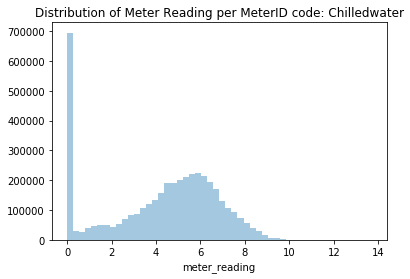

In [22]:
sns.distplot(np.log1p(train[train['meter'] == 1]['meter_reading']), kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Chilledwater")

#### building_metadata

In [23]:
building_metadata.info()
# missing values in year_built

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 5 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 56.7+ KB


In [24]:
cols = ['site_id','primary_use','year_built']
for col in cols:
    print ("Unique Values in the {} column are:".format(col), building_metadata[col].unique())
    print ("\n")

Unique Values in the site_id column are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


Unique Values in the primary_use column are: ['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']


Unique Values in the year_built column are: [2008. 2004. 1991. 2002. 1975. 2000. 1981. 1989. 2003. 2010. 1968. 1999.
 2013. 1974. 1996. 1980. 1977. 1990. 1985. 2001. 1969. 2005. 2016. 2006.
 2014. 1970. 1971. 2011. 1997. 2007. 1998. 2009. 1979. 1986. 1982. 1983.
   nan 1913. 1953. 1909. 1958. 1960. 1976. 1906. 1900. 1995. 1956. 1930.
 1967. 1919. 1955. 1965. 1907. 2012. 1992. 1948. 1950. 1941. 1957. 1964.
 1940. 1951. 1966. 1934. 1959. 1993. 1939. 1918. 1963. 1987. 1914. 1973.
 1988. 1935. 1942. 2015. 1931. 1928. 1929. 1908. 1927. 1923. 1962. 1944.
 1910. 1949. 2017. 1922. 1911. 1

Text(0, 0.5, 'Count')

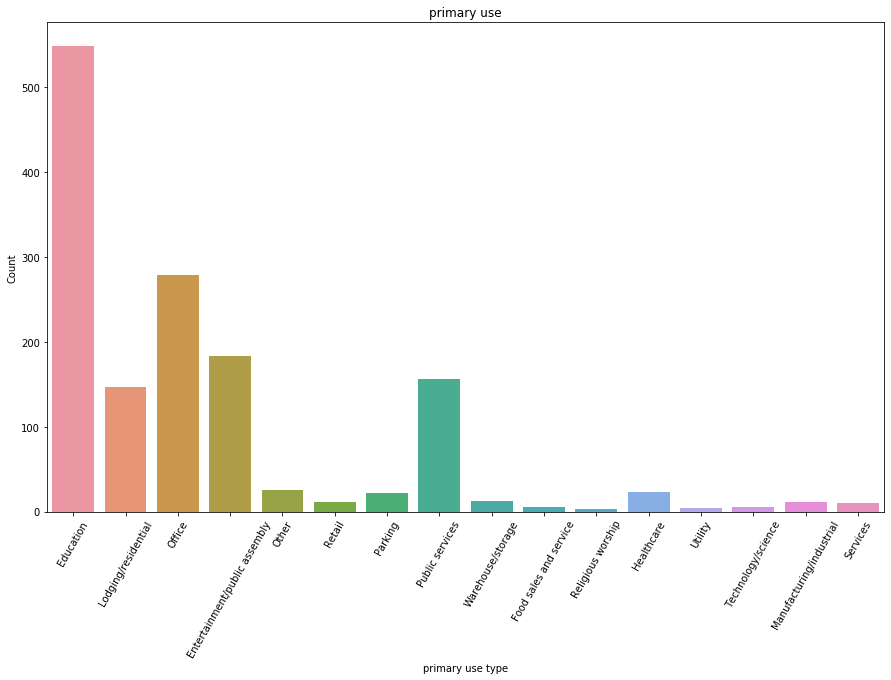

In [25]:
plt.figure(figsize=(15,9))
sns.countplot(building_metadata['primary_use'])
plt.title("primary use")
plt.xlabel("primary use type")
plt.xticks(rotation=60)
plt.ylabel("Count")

In [26]:
building_metadata['primary_use'].value_counts(normalize=True)
# only keep the top 5 types of primary use, and then set the others to 'other'
# keep: Education, Office, Entertainment/public assembly, Public services, Lodging/residential

Education                        0.378882
Office                           0.192547
Entertainment/public assembly    0.126984
Public services                  0.107660
Lodging/residential              0.101449
Other                            0.017253
Healthcare                       0.015873
Parking                          0.015183
Warehouse/storage                0.008972
Manufacturing/industrial         0.008282
Retail                           0.007591
Services                         0.006901
Technology/science               0.004141
Food sales and service           0.003451
Utility                          0.002761
Religious worship                0.002070
Name: primary_use, dtype: float64

In [27]:
building_metadata.loc[-building_metadata['primary_use'].isin(['Education', 'Office', 'Entertainment/public assembly', 'Public services', 'Lodging/residential']),['primary_use']] = 'other'

In [28]:
building_metadata['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'other', 'Public services'],
      dtype=object)

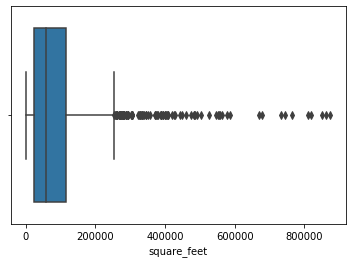

In [29]:
sns.boxplot(building_metadata['square_feet'])

Text(0, 0.5, 'Frequency')

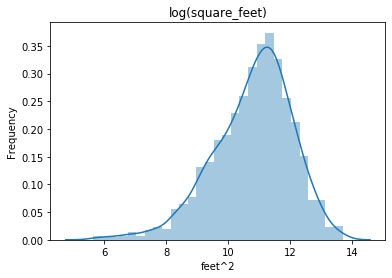

In [30]:
sns.distplot(np.log1p(building_metadata['square_feet']))
plt.title("log(square_feet)")
plt.xlabel("feet^2")
plt.ylabel("Frequency")

### Merge dataset

In [31]:
# train['meter_reading_log1p'] = np.log1p(train['meter_reading'])
target = train.pop('meter_reading')

In [32]:
%%time
train = pd.merge(train, building_metadata,on='building_id',how='left')
test  = pd.merge(test, building_metadata,on='building_id',how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()

Training Data Shape (20216100, 11)
Testing Data Shape (41697600, 12)
CPU times: user 14.5 s, sys: 4.04 s, total: 18.6 s
Wall time: 10.9 s


44

In [33]:
%%time
train = pd.merge(train, weather_train, on=['site_id','timestamp'], how='left')
test  = pd.merge(test, weather_test, on=['site_id','timestamp'], how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()

Training Data Shape (20216100, 18)
Testing Data Shape (41697600, 19)
CPU times: user 21.7 s, sys: 6.29 s, total: 28 s
Wall time: 14.1 s


20

In [37]:
train.head()

,building_id,meter,Month,DayOfMonth,DayOfWeek,Hour,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,1,1,4,0,0,Education,7432,2008.0,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,1,1,4,0,0,Education,2720,2004.0,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,1,1,4,0,0,Education,5376,1991.0,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,1,1,4,0,0,Education,23685,2002.0,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,1,1,4,0,0,Education,116607,1975.0,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [36]:
train.drop('timestamp',axis=1,inplace=True)
test.drop('timestamp',axis=1,inplace=True)

KeyError: "['timestamp'] not found in axis"

In [38]:
columns = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in columns:
    train[col].fillna(train[col].mean(),inplace=True)
    test[col].fillna(test[col].mean(),inplace=True)

In [40]:
primary_use_list = train['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
train['primary_use'] = train['primary_use'].map(primary_use_dict)
test['primary_use'] = test['primary_use'].map(primary_use_dict)

In [41]:
train['primary_use'].unique()

array([0, 1, 2, 3, 4, 5])

In [42]:
train.head()

,building_id,meter,Month,DayOfMonth,DayOfWeek,Hour,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,1,1,4,0,0,0,7432,2008.0,25.0,6.0,20.0,0.796416,1019.7,0.0,0.0
1,1,0,1,1,4,0,0,0,2720,2004.0,25.0,6.0,20.0,0.796416,1019.7,0.0,0.0
2,2,0,1,1,4,0,0,0,5376,1991.0,25.0,6.0,20.0,0.796416,1019.7,0.0,0.0
3,3,0,1,1,4,0,0,0,23685,2002.0,25.0,6.0,20.0,0.796416,1019.7,0.0,0.0
4,4,0,1,1,4,0,0,0,116607,1975.0,25.0,6.0,20.0,0.796416,1019.7,0.0,0.0


## Fit scikit-learn Model

In [43]:
categorical_features = ["building_id", "site_id", "meter", "primary_use"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.75,
    "reg_lambda": 2,
    'reg_alpha': 0.5,
    "metric": "rmse",
}

## Evaluation Matric

In [44]:
kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(train):
    train_features = train.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = train.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 52235.3	valid_1's rmse: 129282
[50]	training's rmse: 24789.4	valid_1's rmse: 123458
[75]	training's rmse: 16660.9	valid_1's rmse: 125949
Early stopping, best iteration is:
[43]	training's rmse: 29888.6	valid_1's rmse: 123272
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 58265.2	valid_1's rmse: 137492
[50]	training's rmse: 30822.8	valid_1's rmse: 140725
[75]	training's rmse: 21708.8	valid_1's rmse: 143409
Early stopping, best iteration is:
[28]	training's rmse: 52400.9	valid_1's rmse: 136700
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 74140.5	valid_1's rmse: 47599.1
[50]	training's rmse: 36368.3	valid_1's rmse: 47445.6
Early stopping, best iteration is:
[2]	training's rmse: 173707	valid_1's rmse: 42878.9
